*******
# Inference

Note: I did have to change the income threshold to $33,132 because I used the wrong year. The year is 2016, with units of 2019 CPI-U-RS Adjusted Dollars. My data was not working properly and I found out that I used the wrong threshold which was previously 36,000.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.linear_model as lm

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set(rc = {'axes.titlesize': 28,
             'axes.labelsize': 26,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'figure.figsize': (12, 8)})

df_p = pd.read_pickle('C:/Users/Marko/Documents/ECON 490 AML Data/final_income.pkl')


In [2]:
df_prep = df_p.drop(columns = ['marst', 'in_wage'])

y = df_prep['bin_wage']
x = df_prep.drop(columns = 'bin_wage')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.1, random_state = 490)
x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)


In [3]:
%%time
param_grid = {
    'C': 10.0**np.arange(-5, 5, step = 1)
}

lr_cv = lm.LogisticRegression(penalty = 'l1', solver = 'liblinear',
                              max_iter = 1e3, random_state = 490)
grid_search = GridSearchCV(lr_cv, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = 10)
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

Wall time: 9.97 s


{'C': 100.0}

In [4]:
fit_logit_reg = sm.Logit(y_train, x_train_std).fit_regularized(alpha = 1/best['C'], L1_wt = 1, qc_tol = 1e3)
print(fit_logit_reg.params)
fit_logit_reg.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5780879494311103
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
const           0.250919
uhrswork        0.172438
experience      0.155916
female          0.000000
any_kids        0.013937
black           0.057513
hispanic       -0.019891
some_college    0.000000
hs_or_less     -0.186490
ba_or_more      0.105739
occ_ba          0.868471
age_mar         0.086077
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               bin_wage   No. Observations:                54680
Model:                          Logit   Df Residuals:                    54670
Method:                           MLE   Df Model:                            9
Date:                Fri, 14 May 2021   Pseudo R-squ.:                  0.1610
Time:                        15:27:22   Log-Likelihood:                -31656.
converged:                       True   LL-Null:                       -37733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2509      0.010     25.164      0.000       0.231       0.270
uhrswork         0.1724      0.010     17.557      0.000       0.153       0.192
experience       0.1559      0.012     13.377      0.000       0.133       0.179
female                0        nan        nan        nan         nan         nan
any_kids         0.0139      0.010      1.332      0.183      -0.007       0.034
black            0.0575      0.010      6.029      0.000       0.039       0.076
hispanic        -0.0199      0.009     -2.095      0.036      -0.039      -0.001
some_college          0        nan        nan        nan         nan         nan
hs_or_less      -0.1865      0.011    -17.276      0.000      -0.208      -0.165
ba_or_more       0.1057      0.013      8.233      0.000       0.081       0.131
occ_ba           0.8685      0.014     61.164      0.000       0.841       0.896
age_mar          0.0861      0.012      6.886      0.000       0.062       0.111
================================================================================
"""

In [5]:
beta = fit_logit_reg.params
beta.index[beta == 0]

Index(['female', 'some_college'], dtype='object')

In [6]:
x_train_std_trim = x_train_std.loc[:, ~x_train_std.columns.isin(beta.index[beta == 0])]
x_test_std_trim = x_test_std.loc[:, ~x_test_std.columns.isin(beta.index[beta == 0])]

In [7]:
fit_std_final = sm.Logit(y_train, x_train_std_trim).fit()
fit_std_final.summary()

Optimization terminated successfully.
         Current function value: 0.578659
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               bin_wage   No. Observations:                54680
Model:                          Logit   Df Residuals:                    54670
Method:                           MLE   Df Model:                            9
Date:                Fri, 14 May 2021   Pseudo R-squ.:                  0.1614
Time:                        15:27:22   Log-Likelihood:                -31641.
converged:                       True   LL-Null:                       -37733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2526      0.010     25.315      0.000       0.233       0.272
uhrswork       0.1551      0.010     15.792      0.000       0.136       0.174
experience     0.1521      0.012     13.029      0.000       0.129       0.175
any_kids       0.0180      0.010      1.714      0.086      -0.003       0.038
black          0.0617      0.010      6.457      0.000       0.043       0.080
hispanic      -0.0189      0.010     -1.984      0.047      -0.038      -0.000
hs_or_less    -0.2349      0.011    -21.725      0.000      -0.256      -0.214
ba_or_more     0.0587      0.013      4.562      0.000       0.033       0.084
occ_ba         0.8783      0.014     61.666      0.000       0.850       0.906
age_mar        0.0924      0.013      7.381      0.000       0.068       0.117
==============================================================================
"""

An increase in one's occupation's bachelor's degree share by one standard deviation is associated with an increase in the probability of having less than or equal to 33,132 of income relative to having more than 33,132 dollars or more by 17.38%.

An increase in one's high school or less degree by one standard deviation is associated with a decrease in the probability of having less than or equal to 33,132 of income relative to having more than 33,132 dollars or more by 4.65%.

An increase in one's experience by one standard deviation is associated with an increase in the probability of having less than or equal to 33,132 of income relative to having more than 33,132 dollars or more by 2.03%.

*******
# Prediction

## Model 1: Inference Model

In [8]:
fit_logit = lm.LogisticRegression().fit(x_train_std_trim, y_train)
yhat = fit_logit.predict(x_test_std_trim)
acc_logit = np.mean(y_test == yhat)
acc_logit

0.6920288382602758

## Model 2: Random Forest

In [9]:
le = LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test  = le.transform(y_test)

clf_bag_tree = RandomForestClassifier(n_estimators = 500,
                          random_state = 490,
                          max_features = 'sqrt',
                          oob_score = True,
                          n_jobs = 10,
                          verbose = 1)
clf_bag_tree.fit(x_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    5.6s finished


RandomForestClassifier(max_features='sqrt', n_estimators=500, n_jobs=10,
                       oob_score=True, random_state=490, verbose=1)

In [10]:
acc_bag_tree = clf_bag_tree.score(x_test, y_test)
acc_bag_tree

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   11.7s finished


0.7311551560175891

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   11.7s finished


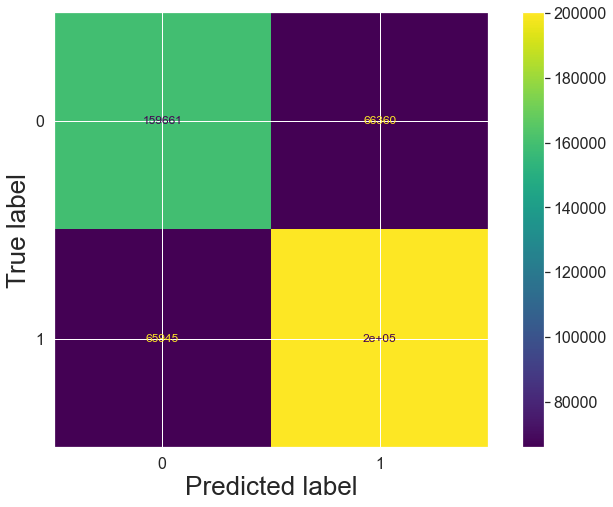

In [11]:
plot_confusion_matrix(clf_bag_tree, x_test, y_test)
plt.show()

## Model 3: XGBoost

In [12]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train_std, y_train,
                                                                           train_size = 2/3,
                                                                           random_state = 490)

In [13]:
reg_xgb = xgb.XGBRegressor(n_estimators = 500,
                          max_depth = 2, 
                          learning = 1,
                          random_state = 490,
                          use_label_encoder = False)

reg_xgb.fit(x_train_train, y_train_train,
           eval_set = [(x_train_test, y_train_test)],
           early_stopping_rounds = 4)

[15:27:57] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.47313
[1]	validation_0-rmse:0.45898
[2]	validation_0-rmse:0.45059
[3]	validation_0-rmse:0.44544
[4]	validation_0-rmse:0.44211
[5]	validation_0-rmse:0.43981
[6]	validation_0-rmse:0.43822
[7]	validation_0-rmse:0.43733
[8]	validation_0-rmse:0.43627
[9]	validation_0-rmse:0.43567
[10]	validation_0-rmse:0.43481
[11]	validation_0-rmse:0.43406
[12]	validation_0-rmse:0.43379
[13]	validation_0-rmse:0.43289
[14]	validation_0-rmse:0.43248
[15]	validation_0-rmse:0.43183
[16]	validation_0-rmse:0.43030
[17]	validation_0-rmse:0.42893
[18]	validation_0-rmse:0.42849
[19]	validation_0-rmse:0.42800
[20]	validation_0-rmse:0.42517
[21]	validation_0-rmse:0.42399


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='', learning=1,
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=490,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [14]:
best_reg_xgb = reg_xgb.get_booster().best_iteration
print("Best Iteration: {}".format(best_reg_xgb))

Best Iteration: 396


In [15]:
reg_xgb_2 = xgb.XGBClassifier(n_estimators = best_reg_xgb, 
                          max_depth = 2, 
                          learning = 1,
                          random_state = 490,
                          use_label_encoder = False)
reg_xgb_2.fit(x_train_train, y_train_train,
             eval_set = [(x_train_test, y_train_test)],
           early_stopping_rounds = 4)

[15:27:59] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:27:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.64081
[1]	validation_0-logloss:0.61292
[2]	validation_0-logloss:0.59542
[3]	validation_0-logloss:0.58466
[4]	validation_0-logloss:0.57719
[5]	validation_0-logloss:0.57105
[6]	validation_0-logloss:0.56757
[7]	validation_0-logloss:0.56390
[8]	validation_0-logloss:0.56120
[9]	validation_0-logloss:0.55878
[10]	validation_0-logloss:0.55670
[11]	validation_0-logloss:0.55530
[12]	validation_0-logl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='', learning=1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=396, n_jobs=8, num_parallel_tree=1, random_state=490,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [16]:
acc_xgb = reg_xgb_2.score(x_train_test, y_train_test)
acc_xgb

0.7883359850770835

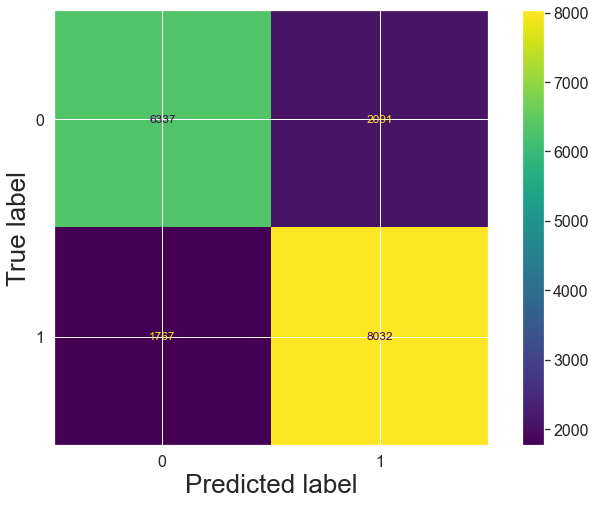

In [17]:
plot_confusion_matrix(reg_xgb_2, x_train_test, y_train_test)
plt.show()

## Stacking Ensemble

In [18]:
estimator = [('xgb', xgb.XGBClassifier(n_estimators = best_reg_xgb, 
                          max_depth = 2, 
                          learning = 1,
                          random_state = 490,
                          use_label_encoder = False)), ('rf', RandomForestClassifier(n_estimators = 500,
                          random_state = 490,
                          max_features = 'sqrt',
                          oob_score = True,
                          n_jobs = 10,
                          verbose = 1)), ('logit', fit_logit)]
stack_clf = StackingClassifier(estimators = estimator, final_estimator = LogisticRegression(solver ='saga'), cv = 5).fit(x_train, y_train)

[15:28:01] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    6.9s finished


[15:28:14] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:28:16] WARNING: ..\src\learner.cc:541: 
Parameters: { learning } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluatio

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    5.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    5.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tas

In [19]:
acc_stack = stack_clf.score(x_test, y_test)
print(acc_stack)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   10.8s


0.8008245889247425


[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   12.5s finished


*******
# Comparison

|                |Performance (Accuracy)| 
|----------------|----------------------|
| Binomial Logit | 0.6920288382602758   |  
| Random Forest  | 0.7311551560175891   |    
| XGBoost        | 0.7883359850770835   |        
| Stacking       | 0.8008245889247425   |       

It is not easy to interpret the Stacking Ensemble, XGBoost and Random Forest models, but the Binomial Logit model can be interpreted with ease. The best performing model was the Stacking Ensemble model. It slightly outperforms XGBoost. The Stacking Ensemble model had an accuracy improvement of over 6 percentage points in comparison to the Random Forest model. Also, the accuracy improvement is over 10 percentage points in comparison to the Binomial Logit model. The XGBoost model, Random Forest, and the Stacking Ensemble appear to be the most flexible, with Binomial Logit being the least flexible.